# Evaluate inversion results

This notebook evaluates and plot the results of the gravity and magnetic only inversions. <br>

**jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 15/05/2023**


#### Import library

In [1]:
import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from cmcrameri import cm
import cartopy.crs as ccrs
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
Topo_values_regridded_pd = pd.read_csv('DATA/exported_Topo_values_regridded.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'topo' ])

CDP_above_Moho_regridded_pd = pd.read_csv('DATA/exported_CDP_above_Moho_regridded.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'CDP_above_Moho' ])

Topo_values_regridded = Topo_values_regridded_pd.to_numpy()
CDP_above_Moho_regridded = CDP_above_Moho_regridded_pd.to_numpy()


study_area_pd = pd.read_csv('DATA/study_padding_area.txt', skiprows=1, 
                        names=['x_stu' , 'y_stu' , 'x_pad' , 'y_pad' ])

study_area = study_area_pd.to_numpy()
Coastline = pd.read_pickle('DATA/costline_wsb.pkl')


In [3]:
unit_dens = 'kg/m$^3$'
unit_sus = 'SI'

In [4]:
## load shifted data
shift_values_pd = pd.read_csv('DATA/exported_shift_value.txt', skiprows=1, names=['x_shift' , 'y_shift'])
shift_values = shift_values_pd.to_numpy()

###### Observed gravity data ######
nc = nc4.Dataset('Grav_Mag_only_inversion/Grav_only_inversion_shifted_AntGG_residual_grav_re10/MI_inversion/gravdata.nc')  # grav data set
X_input_grav = nc.variables['MeasPosX'][:] - (shift_values[0,0]*2) # x coordinates
Y_input_grav = nc.variables['MeasPosY'][:] - (shift_values[0,1]*2) # y coordinates 
val_input_grav = nc.variables['Scalar_gravity'][:] *1e5  # gravity data converted from SI units to mGal
unit_grav = 'mGal'

##### Inverted gravity data ######
G = nc4.Dataset('Grav_Mag_only_inversion/Grav_only_inversion_shifted_AntGG_residual_grav_re10/MI_inversion/result.inv_sgd.nc')   # syn grav data set
X_syn_grav = G.variables['MeasPosX'][:] - (shift_values[0,0]*2) # x coordinates
Y_syn_grav = G.variables['MeasPosY'][:] - (shift_values[0,1]*2) # y coordinates 
val_syn_grav = G.variables['Scalar_gravity'][:]*1e5  # syn gravity data

diff_grav = val_input_grav - val_syn_grav  # difference observed and syn gravity data
mxn_d=max(abs(max(diff_grav)),abs(min(diff_grav)))
diff_grav_pd = pd.DataFrame(diff_grav, columns = ['diff_grav'])

nc.close()
G.close()



In [5]:
##### Mag data ######
nc1 = nc4.Dataset('Grav_Mag_only_inversion/Mag_only_inversion_reg10/MI_inversion/magdata.nc')  # mag data set
X_input_mag = nc1.variables['MeasPosX'][:] - (shift_values[0,0]*2) # x coordinates
Y_input_mag = nc1.variables['MeasPosY'][:] - (shift_values[0,1]*2) # y coordinates
val_input_mag = nc1.variables['T'][:]   # magnetic data
unit_mag = 'nT'

##### Inverted mag data ######
G1 = nc4.Dataset('Grav_Mag_only_inversion/Mag_only_inversion_reg10/MI_inversion/result.inv_mag.nc')   # syn mag data set
X_syn_mag = G1.variables['MeasPosX'][:] - (shift_values[0,0]*2) # x coordinates
Y_syn_mag = G1.variables['MeasPosY'][:] - (shift_values[0,1]*2) # y coordinates
val_syn_mag = G1.variables['T'][:]       # syn magnetic data


diff_mag = val_input_mag - val_syn_mag  # difference observed and syn gravity data
mxn_d=max(abs(max(diff_mag)),abs(min(diff_mag)))
diff_mag_pd = pd.DataFrame(diff_mag, columns = ['diff_mag'])

nc1.close()
G1.close()

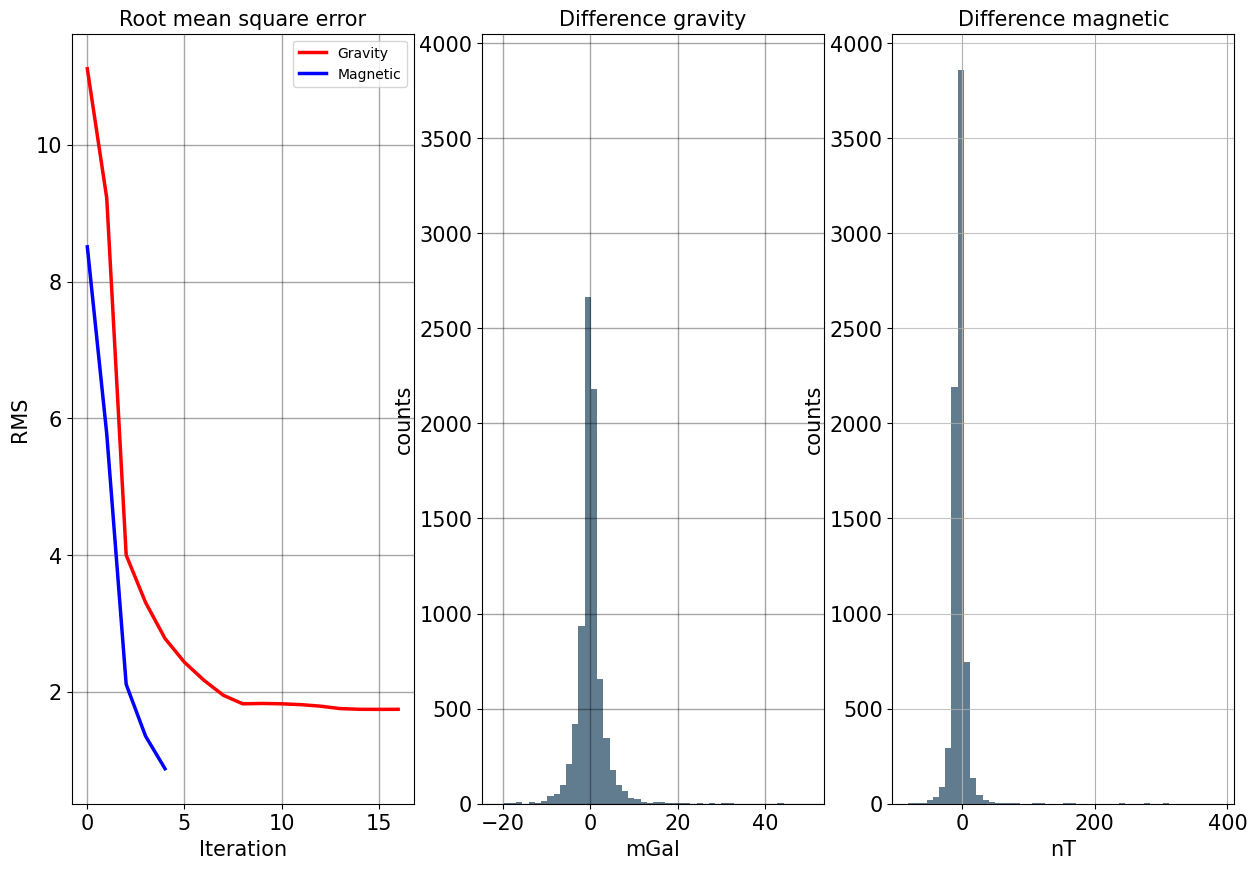

In [6]:
# load missift and rms data 
rms_grav = np.genfromtxt("Grav_Mag_only_inversion/Grav_only_inversion_shifted_AntGG_residual_grav_re10/MI_inversion/rms.out")
rms_mag = np.genfromtxt("Grav_Mag_only_inversion/Mag_only_inversion_reg10/MI_inversion/rms.out")


figure1, axs = plt.subplots(1, 3, figsize=(15,10),facecolor='white')

axs[0].plot(rms_grav[:,1] , '-r' , linewidth=2.5 , label='Gravity')
axs[0].plot(rms_mag[:,1] , '-b' , linewidth=2.5 , label='Magnetic')

axs[0].legend(loc='upper right' , prop={'size': 10})
axs[0].set_title("Root mean square error" , fontsize=15)
axs[0].set_xlabel('RMS', fontsize=15)
axs[0].grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
axs[0].set_xlabel('Iteration' , fontsize=15)
axs[0].set_ylabel('RMS' , fontsize=15)
axs[0].tick_params(axis="x", labelsize=15) 
axs[0].tick_params(axis="y", labelsize=15) 

diff_grav_pd.diff_grav.plot.hist(grid=True, bins=50 , ax=axs[1] ,  color='#607c8e')
axs[1].set_title('Difference gravity', fontsize=15)
axs[1].set_xlabel('mGal', fontsize=15)
axs[1].set_ylabel('counts', fontsize=15)
axs[1].grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
axs[1].tick_params(axis="x", labelsize=15) 
axs[1].tick_params(axis="y", labelsize=15)


diff_mag_pd.diff_mag.plot.hist(grid=True, bins=50 , ax=axs[2] ,  color='#607c8e')
axs[2].set_title('Difference magnetic', fontsize=15)
axs[2].set_xlabel('nT', fontsize=15)
axs[2].set_ylabel('counts', fontsize=15)
axs[2].grid(axis='y', alpha=0.75)
axs[2].tick_params(axis="x", labelsize=15) 
axs[2].tick_params(axis="y", labelsize=15) 

axs[1].sharey(axs[2])


# plt.savefig(export_fig_path + 'dens_sus_only_inversion_stats.png',facecolor=figure1.get_facecolor(), transparent=True)

Text(0.5, 1.0, 'nT')

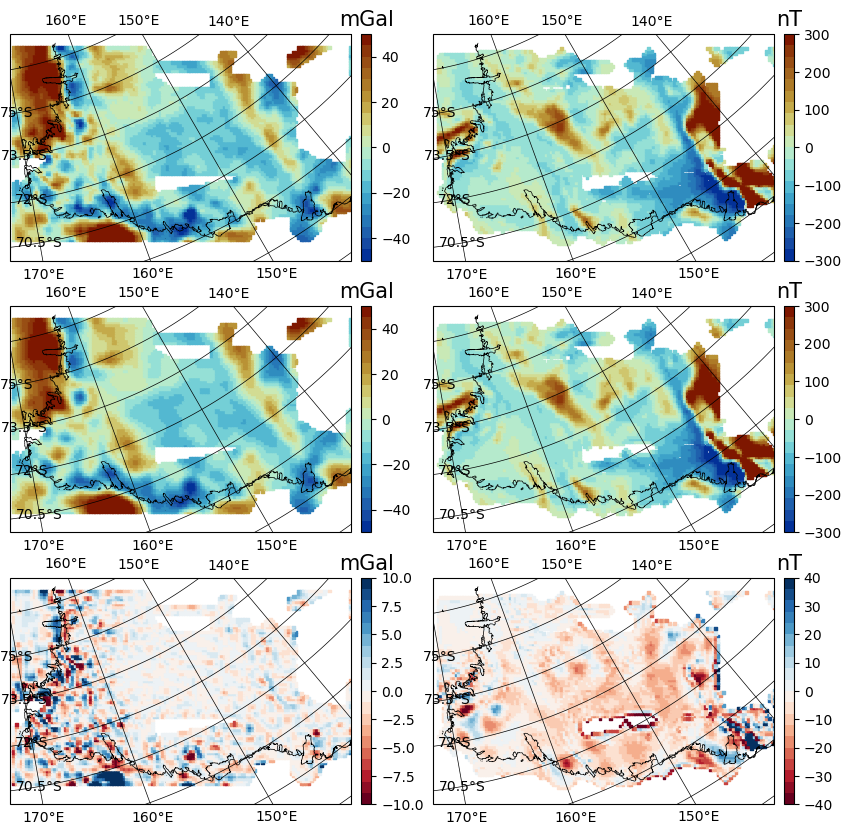

In [7]:
m=15 #fontsize
cmap = cm.roma_r.resampled(20)
cmap_rev = cm.roma_r.resampled(20)
cmap_grav_diff = plt.get_cmap('RdBu',20)


figure1 = plt.figure(figsize=(10,10),facecolor='white')
# fig.tight_layout()

ax1 = plt.subplot(3, 2, 1 , projection=ccrs.SouthPolarStereo())
# plt.title('observed gravity anomaly',fontsize=m)

ax1.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
im = plt.scatter(X_input_grav , Y_input_grav , c=val_input_grav , marker='s', s=4, cmap = cmap_rev, vmin=-50, vmax=50 , transform=ccrs.SouthPolarStereo())
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb1 = plt.colorbar(im, cax=cax)
cb1.ax.set_title(unit_grav,fontsize=m)

ax2 = plt.subplot(3, 2, 3 , projection=ccrs.SouthPolarStereo())
# plt.title('inverted gravity anomaly',fontsize=m)
ax2.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im2 = plt.scatter(X_syn_grav , Y_syn_grav , c=val_syn_grav, marker='s', s=4, cmap =cmap_rev , vmin=-50, vmax=50 , transform=ccrs.SouthPolarStereo())
Coastline.plot(ax=ax2 , color = 'k' , linewidth = 0.5)
ax2.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb2 = plt.colorbar(im2, cax=cax)
cb2.ax.set_title(unit_grav,fontsize=m)

ax3 = plt.subplot(3, 2, 5 , projection=ccrs.SouthPolarStereo())
# plt.title('Difference \n observed - inversion model',fontsize=m)
ax3.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im3 = plt.scatter(X_input_grav , Y_input_grav , c=diff_grav , marker='s' , s=4 , cmap=cmap_grav_diff , vmin=-10 , vmax=10 , transform=ccrs.SouthPolarStereo()) #, vmin=-mxn_d/10, vmax=mxn_d/10)
Coastline.plot(ax=ax3 , color = 'k' , linewidth = 0.5)
ax3.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb3 = plt.colorbar(im3, cax=cax)
cb3.ax.set_title(unit_grav,fontsize=m)

ax4 = plt.subplot(3, 2, 2 , projection=ccrs.SouthPolarStereo())
# plt.title('observed gravity anomaly',fontsize=m)
ax4.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
Coastline.plot(ax=ax4 , color = 'k' , linewidth = 0.5)
im = plt.scatter(X_input_mag , Y_input_mag , c=val_input_mag , marker='s', s=4, cmap = cmap_rev, vmin=-300, vmax=300 , 
                 transform=ccrs.SouthPolarStereo())
ax4.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb1 = plt.colorbar(im, cax=cax)
cb1.ax.set_title(unit_mag,fontsize=m)

ax5 = plt.subplot(3, 2, 4 , projection=ccrs.SouthPolarStereo())
# plt.title('inverted gravity anomaly',fontsize=m)
ax5.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im2 = plt.scatter(X_syn_mag , Y_syn_mag , c=val_syn_mag, marker='s', s=4, cmap =cmap_rev , vmin=-300, vmax=300 , 
                  transform=ccrs.SouthPolarStereo())
Coastline.plot(ax=ax5 , color = 'k' , linewidth = 0.5)
ax5.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb2 = plt.colorbar(im2, cax=cax)
cb2.ax.set_title(unit_mag,fontsize=m)

ax6 = plt.subplot(3, 2, 6 , projection=ccrs.SouthPolarStereo())
# plt.title('Difference \n observed - inversion model',fontsize=m)
ax6.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im3 = plt.scatter(X_input_mag , Y_input_mag , c=diff_mag , marker='s' , s=4 , cmap=cmap_grav_diff , vmin=-40 , vmax=40 , transform=ccrs.SouthPolarStereo()) #, vmin=-mxn_d/10, vmax=mxn_d/10)
Coastline.plot(ax=ax6 , color = 'k' , linewidth = 0.5)
ax6.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb3 = plt.colorbar(im3, cax=cax)
cb3.ax.set_title(unit_mag,fontsize=m)


In [8]:
#read in magnetic inversion model
mag_fh = Dataset('Grav_Mag_only_inversion/Mag_only_inversion_reg10/MI_inversion/result.mag.inv.nc')
X_sus = mag_fh.variables["Northing"][:] - (shift_values[0,0]*2)
Y_sus =mag_fh.variables["Easting"][:] - (shift_values[0,1]*2)
Depth_sus =mag_fh.variables["Depth"][:]
X_sus_Origin =mag_fh.variables["Northing_Origin"][:] - (shift_values[0,0]*2)
Y_sus_Origin =mag_fh.variables["Easting_Origin"][:] - (shift_values[0,1]*2)
Depth_sus_Origin =mag_fh.variables["Depth_Origin"][:]
inv_sus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()

#and the corresponding gravity model, do not need geometry as we know it is the same
grav_fh = Dataset('Grav_Mag_only_inversion/Grav_only_inversion_shifted_AntGG_residual_grav_re10/MI_inversion/result.grav.inv.nc')
inv_dens = grav_fh.variables["Density"][:,:,:]
grav_fh.close()


MI_cov = nc4.Dataset('VI_inversion_shifted_AntGG_residual_grav_gravmag_reg10_coupling_15e3_run2/VI_inversion/MI_cov.nc') 
XX_mag_mesh = MI_cov.variables['Northing'][:]
YY_mag_mesh = MI_cov.variables['Easting'][:]
MI_cov_mesh = MI_cov.variables['Density'][:]

MI_cov.close()

In [9]:
xq , yq = np.meshgrid(X_sus , Y_sus)
# Depth_inversion_km = np.round((Depth_sus/1000),1)
Depth_inversion_km = Depth_sus/1000

x_stack_ix = []
y_stack_ix = []
z_stack_ix = []

for i in range(len(Depth_inversion_km)):
    
    x_stack_ix.append(xq)
    y_stack_ix.append(yq)
    
    z_stack_zeros = np.zeros((len(xq[:,0]), len(xq[0,:])))
    z_stack_zeros[:,:] = Depth_inversion_km[i]*1000
    z_stack_ix.append(z_stack_zeros)
    
x_stack = np.array(x_stack_ix)
y_stack = np.array(y_stack_ix)
z_stack = np.array(z_stack_ix)

crossplot_data =  np.vstack((inv_sus.flatten() , inv_dens.flatten() , x_stack.flatten() , y_stack.flatten() ,
                             z_stack.flatten() , MI_cov_mesh.flatten())).T

In [10]:
crossplot_data_cleaned_ix = []

for i in range(len(crossplot_data[:,0])):
    if crossplot_data[i,5] == 1:
        crossplot_data_cleaned_ix.append(crossplot_data[i,:])
crossplot_data_cleaned = np.array(crossplot_data_cleaned_ix)        

In [11]:
crossplot_data_cleaned_study_area_ix = []
for i in range(len(crossplot_data_cleaned[:,0])):
    if (crossplot_data_cleaned[i,2]> study_area[0,0] and crossplot_data_cleaned[i,2]< study_area[1,0] 
       and crossplot_data_cleaned[i,3]> study_area[0,1] and crossplot_data_cleaned[i,3]< study_area[2,1]):
        crossplot_data_cleaned_study_area_ix.append(crossplot_data_cleaned[i,:])
crossplot_data_cleaned_study_area = np.array(crossplot_data_cleaned_study_area_ix)

crossplot_data_cleaned = []
crossplot_data_cleaned = crossplot_data_cleaned_study_area


Text(0.5, 0, 'counts')

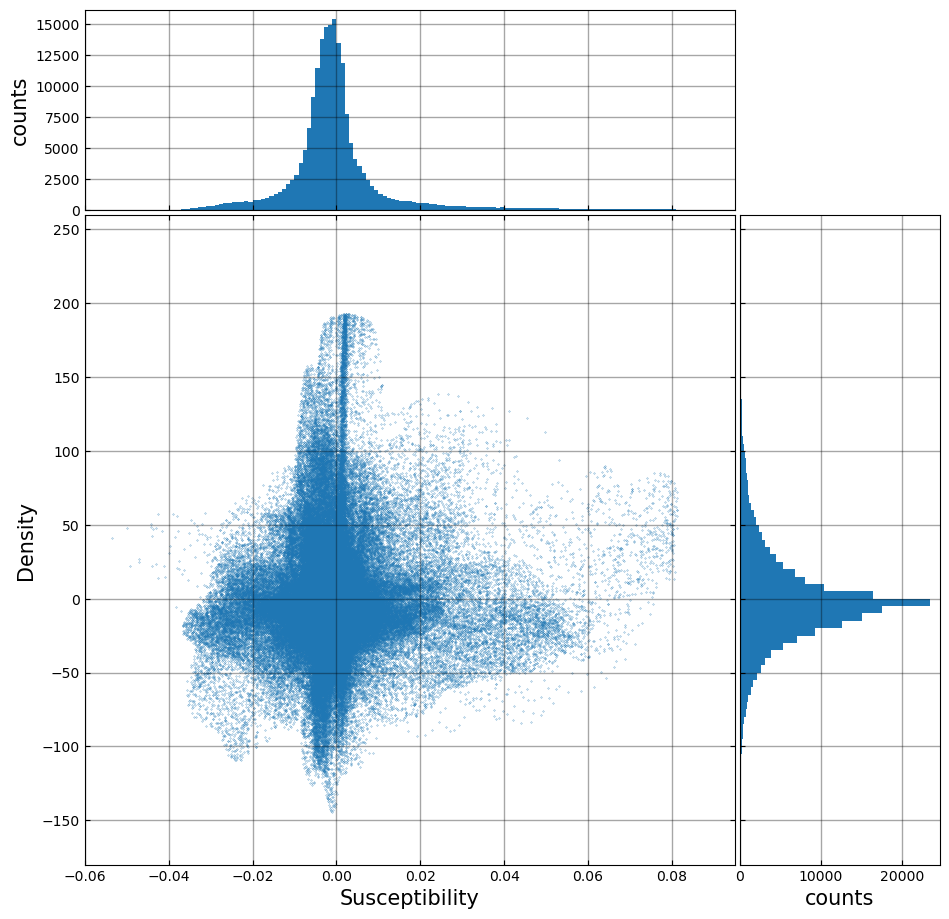

In [12]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10,10) , facecolor='white')


ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(crossplot_data_cleaned[:,0],crossplot_data_cleaned[:,1] , 0.05)
ax_scatter.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax_scatter.set_xlabel('Susceptibility' , fontsize=15)
ax_scatter.set_ylabel('Density' , fontsize=15)
ax_scatter.set_xlim((-0.06, 0.095)) 
ax_scatter.set_ylim((-180, 260))


# x histogramm
x_binwidth = 0.001  # bin size
x_bins = np.arange(-0.06, 0.095 + x_binwidth, x_binwidth) # set histogramm bin limes to scatter limites
ax_histx.hist(crossplot_data_cleaned[:,0], bins=x_bins) # histogramm plot
ax_histx.set_xlim(ax_scatter.get_xlim())  # set limites to scatter limites
ax_histx.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax_histx.set_ylabel('counts' , fontsize=15)

# y histo 
y_binwidth = 5 # bin size
y_bins = np.arange(-180, 260 + y_binwidth, y_binwidth) # set histogramm bin limes to scatter limites
ax_histy.hist(crossplot_data_cleaned[:,1], bins=y_bins , orientation='horizontal') # histogramm plot
ax_histy.set_ylim(ax_scatter.get_ylim()) # set limites to scatter limites
ax_histy.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax_histy.set_xlabel('counts' , fontsize=15)


In [13]:
xq , yq = np.meshgrid(X_sus , Y_sus)
Depth_inversion_km = np.round((Depth_sus/1000),1)

In [14]:
x_max_inv = max(X_syn_grav)
x_min_inv = min(X_syn_grav)
y_max_inv = max(Y_syn_grav)
y_min_inv = min(Y_syn_grav)

profil_numbers = np.arange(18,120,1)

In [15]:
Moho4profile_data_pd = pd.read_csv('DATA/Moho_depth4profile.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'Moho'])
Moho4profile_data = Moho4profile_data_pd.to_numpy()

CDP4profile_data_pd = pd.read_csv('DATA/CDP_depth4profile.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'CDP_above_Moho'])
CDP4profile_data = CDP4profile_data_pd.to_numpy()

Topo4profile_data_pd = pd.read_csv('DATA/Topo_depth4profile.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'Topo'])
Topo4profile_data = Topo4profile_data_pd.to_numpy()


x_moho_profil_grid = np.reshape(Moho4profile_data[:,0]- (shift_values[0,0]*2),(xq.shape[0],xq.shape[1]))
y_moho_profil_grid = np.reshape(Moho4profile_data[:,1]- (shift_values[0,1]*2),(xq.shape[0],xq.shape[1]))
z_moho_profil_grid = np.reshape(Moho4profile_data[:,2],(xq.shape[0],xq.shape[1]))

x_cdp_profil_grid = np.reshape(CDP4profile_data[:,0]- (shift_values[0,0]*2),(xq.shape[0],xq.shape[1]))
y_cdp_profil_grid = np.reshape(CDP4profile_data[:,1]- (shift_values[0,1]*2),(xq.shape[0],xq.shape[1]))
z_cdp_profil_grid = np.reshape(CDP4profile_data[:,2],(xq.shape[0],xq.shape[1]))

x_topo_profil_grid = np.reshape(Topo4profile_data[:,0]- (shift_values[0,0]*2),(xq.shape[0],xq.shape[1]))
y_topo_profil_grid = np.reshape(Topo4profile_data[:,1]- (shift_values[0,1]*2),(xq.shape[0],xq.shape[1]))
z_topo_profil_grid = np.reshape(Topo4profile_data[:,2],(xq.shape[0],xq.shape[1]))

In [16]:
Obsevered_grav =  np.vstack((np.round(X_input_grav) , np.round(Y_input_grav) , val_input_grav)).T
Synthetic_grav =  np.vstack((np.round(X_syn_grav) , np.round(Y_syn_grav) , val_syn_grav)).T
Obsevered_mag =  np.vstack((np.round(X_input_mag) , np.round(Y_input_mag) , val_input_mag)).T
Synthetic_mag =  np.vstack((np.round(X_syn_mag) , np.round(Y_syn_mag) , val_syn_mag)).T


In [17]:
x_profil , z_profil = np.meshgrid(X_sus,Depth_sus)


Text(0.5, 1.0, 'SI')

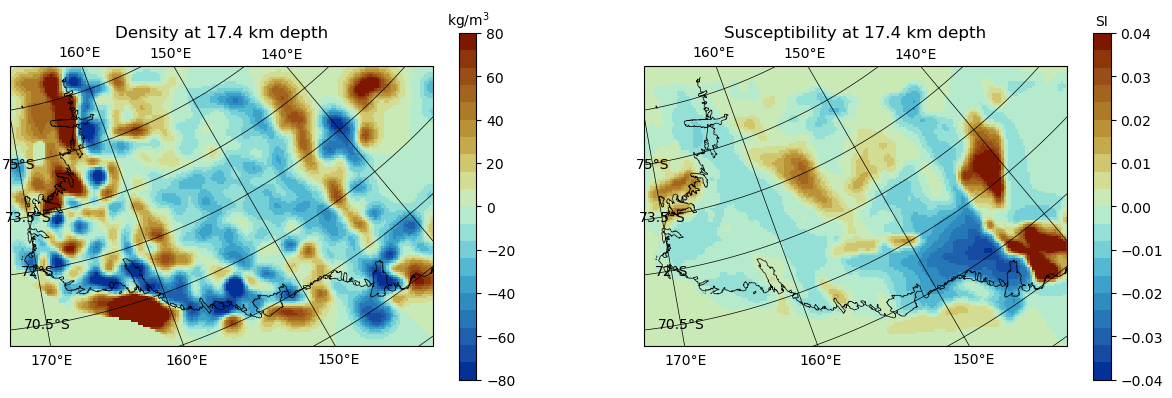

In [18]:
Depth_index = 11  # Choose depth invervall between 0 and 20 relating to the inversion depths (-3000. -1900.  -690.   641.  2105. 3716.  5488.  7437.  9581. 11939. 14533. 17386. 20524. 23976. 27773. 31950. 36545. 41599. 47159. 53275. 60002. [m])
    
    
figure1 = plt.figure(figsize=(15,15),facecolor='white')

inv_dens_depth_slice = inv_dens[Depth_index,:,:]
inv_sus_depth_slice = inv_sus[Depth_index,:,:]

ax3 = plt.subplot(1, 2, 1 , projection=ccrs.SouthPolarStereo())
plt.title("Density at {:.1f} km depth".format(Depth_inversion_km[Depth_index]))
ax3.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im3 = plt.pcolormesh(xq , yq ,inv_dens_depth_slice , cmap = cmap_rev, vmin=-80 , vmax = 80)
Coastline.plot(ax=ax3 , color = 'k' , linewidth = 0.5)
ax3.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cb = plt.colorbar(im3, shrink=0.3)
cb.ax.set_title(unit_dens,fontsize=10)



ax4 = plt.subplot(1, 2, 2 , projection=ccrs.SouthPolarStereo())
plt.title("Susceptibility at {:.1f} km depth".format(Depth_inversion_km[Depth_index]))
ax4.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im4 = plt.pcolormesh(xq , yq ,inv_sus_depth_slice , cmap = cmap_rev  , vmin=-0.04 , vmax = 0.04 )
Coastline.plot(ax=ax4 , color = 'k' , linewidth = 0.5)
ax4.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cb = plt.colorbar(im4, shrink=0.3)
cb.ax.set_title(unit_sus,fontsize=10)

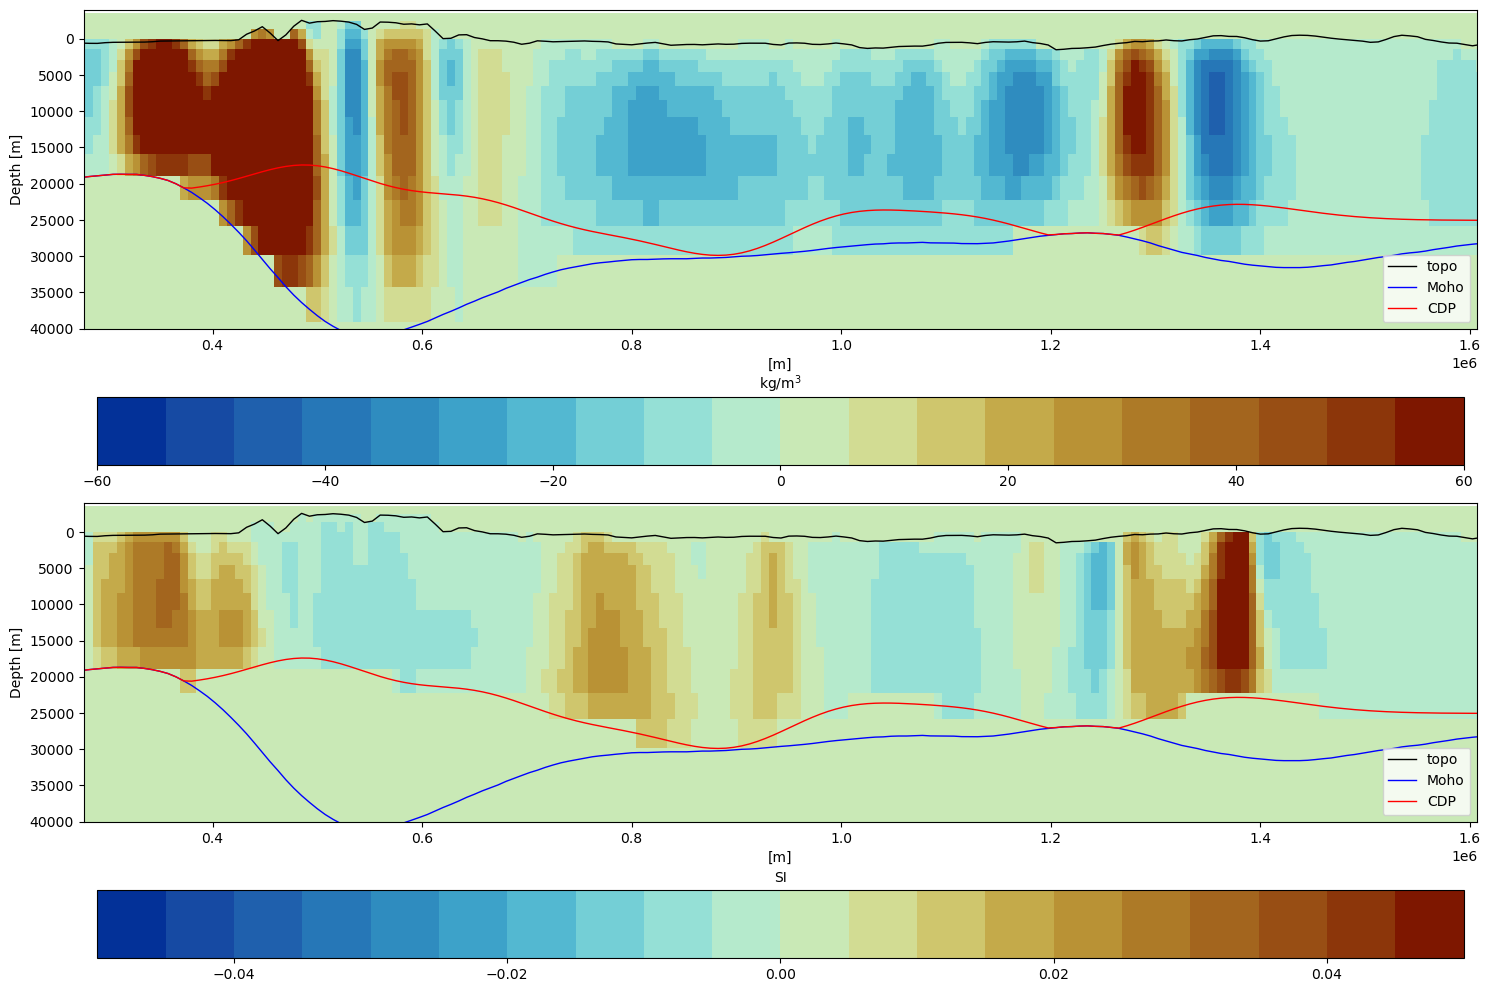

In [19]:

# define fontsize
fontsize_index = 10

y_direction_index = 75
    
sus_profil_ix = inv_sus[:,y_direction_index,:]
dens_profil_ix = inv_dens[:,y_direction_index,:]

## find moho and cdp profile line for current loop run
x_moho_profil_line_data = x_moho_profil_grid[y_direction_index , :]
z_moho_profil_line_data = z_moho_profil_grid[y_direction_index , :]
x_cdp_profil_line_data = x_cdp_profil_grid[y_direction_index , :]
z_cdp_profil_line_data = z_cdp_profil_grid[y_direction_index , :]
x_topo_profil_line_data = x_topo_profil_grid[y_direction_index , :]
z_topo_profil_line_data = z_topo_profil_grid[y_direction_index , :]

   
## plot figure
figure1 = plt.figure(figsize = (15,10),facecolor='white')
spec = figure1.add_gridspec(2, 2)

# plot density profil
ax1 = figure1.add_subplot(spec[0, :])
im1 = plt.pcolormesh(x_profil , z_profil , dens_profil_ix , cmap=cmap_rev , vmin=-60 , vmax=60 , shading='auto')
plt.plot(x_topo_profil_line_data,z_topo_profil_line_data , color='black',linewidth=1 , label='topo')
plt.plot(x_moho_profil_line_data,z_moho_profil_line_data , color='blue',linewidth=1 , label='Moho')
plt.plot(x_cdp_profil_line_data,z_cdp_profil_line_data , color='red',linewidth=1 , label='CDP')
ax1.legend(loc='lower right' ,  prop={'size': 10})
plt.xlabel('[m]', fontsize=fontsize_index)
plt.ylabel('Depth [m]' , fontsize=fontsize_index)
ax1.set_ylim([-4000 , 40000])
ax1.set_xlim([min(study_area[:,0]), max(study_area[:,0])])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im1 , shrink=1 , orientation='horizontal')
cb.ax.set_title(unit_dens ,fontsize=fontsize_index)

# plot sus profil
ax2 = figure1.add_subplot(spec[1, :])
im2 = plt.pcolormesh(x_profil , z_profil , sus_profil_ix , cmap=cmap_rev , vmin=-0.05 , vmax=0.05 , shading='auto')
plt.plot(x_topo_profil_line_data,z_topo_profil_line_data , color='black',linewidth=1 , label='topo')
plt.plot(x_moho_profil_line_data,z_moho_profil_line_data , color='blue',linewidth=1 , label='Moho')
plt.plot(x_cdp_profil_line_data,z_cdp_profil_line_data , color='red',linewidth=1 , label='CDP')
ax2.legend(loc='lower right' ,  prop={'size': 10})
plt.xlabel('[m]', fontsize=fontsize_index)
plt.ylabel('Depth [m]' , fontsize=fontsize_index)
ax2.set_ylim([-4000 , 40000])
ax2.set_xlim([min(study_area[:,0]), max(study_area[:,0])])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2 , shrink=1 , orientation='horizontal')
cb.ax.set_title(unit_sus ,fontsize=fontsize_index)

figure1.tight_layout(pad=1)
            
           